In [1]:
import pyedflib
import numpy as np

In [2]:
import arrow

In [3]:
from datetime import datetime as dt
from datetime import timedelta as td

In [4]:
from bs4 import BeautifulSoup

In [5]:
import matplotlib.pyplot as plt

In [6]:
f = pyedflib.EdfReader('local-data/chat-baseline-300004.edf')

In [7]:
with open('./local-data/chat-baseline-300004-nsrr.xml') as fp:
    annot = BeautifulSoup(fp)

In [8]:
f.samplefrequency(51)

200.00000000000003

In [9]:
f.getFileDuration()

37545

In [10]:
start_dt = arrow.get(f.getStartdatetime())
start_dt

<Arrow [1985-01-01T19:53:10+00:00]>

In [11]:
start_dt.shift(seconds=37545)

<Arrow [1985-01-02T06:18:55+00:00]>

In [12]:
# Uncomment to see the signal details
#f.getSignalHeaders()

In [13]:
# This is how you cleanup the f object
#f._close()
#del f

In [14]:
n = f.signals_in_file
n

52

In [15]:
def read_edf_signals(f, signals):
    labels = f.getSignalLabels()
    indices = [labels.index(signal) for signal in signals]
    sigbufs = np.zeros((len(signals), f.getNSamples()[0]))
    for i, signal_index in enumerate(indices):
        print(f"read {i} from {signal_index}")
        sigbufs[i, :] = f.readSignal(signal_index)
    f._close()
    return sigbufs

In [16]:
def read_edf_signals_file(filename, signals):
    f = pyedflib.EdfReader(filename)
    return read_edf_signals(f, signals)

In [270]:
import scipy.signal as signal

def resample64(abd, chest):
    # Resample to 64Hz
    new_length = int(len(abd)*64/200)
    abd_64 = signal.resample(abd, new_length)
    chest_64 = signal.resample(chest, new_length)

    return abd_64, chest_64

In [271]:
import scipy.signal as signal

def preprocess(sigs):
    '''
    sigs[0] should be ABD
    sigs[1] should be Chest
    '''
    # Resample to 64Hz
    abd_64, chest_64 = resample64(sigs[0], sigs[1])
    
    
    bands =   (0, 0.05, 0.1, 5, 10, 32)
    desired = (0, 0,    1,   1, 0, 0)
    b_firwin = signal.firwin2(73, bands, desired, fs=64)
    #b_firls = signal.firls(73, bands, desired, fs=64)

    abd_64_filt = signal.filtfilt(b_firwin, 1, abd_64)
    chest_64_filt = signal.filtfilt(b_firwin, 1, chest_64)
    return abd_64_filt, chest_64_filt

In [353]:
def calc_taa(abd, chest, win_size=3, freq=64):
    x1 = abd
    x2 = chest
    # win_size = 3
    x_stride = win_size*freq
    half_x_stride = x_stride // 2
    xlen = len(x1)
    win_count = int(np.ceil(xlen/x_stride))
    secs = int(len(x1)/freq)
    taa = np.zeros(secs)
    for i in range(win_count):
        j = max(i * x_stride - half_x_stride, 0)
        j_end = min(i * x_stride + half_x_stride, xlen)
        x1_h = hilbert(x1[j:j_end])
        x2_h = hilbert(x2[j:j_end])
        c = np.inner(x1_h, np.conj(x2_h)) / np.sqrt(np.inner(x1_h, np.conj(x1_h)) * np.inner(x2_h,np.conj(x2_h)))
        phase_angle = np.abs(np.angle(c))
        #phase_angle = np.arctan(c)
        taa[i*win_size:i*win_size+win_size] = phase_angle
    taa_raw = taa.copy()
    taa = np.abs(taa)/np.pi
    return taa

In [354]:
taa = calc_taa(abd, chest)

In [303]:
def read_sleep_stages(total_duration, scored_events):
    #print(len(scored_events))
    stages = np.zeros(total_duration, dtype=np.int8)
    for event in scored_events:
        event_type = event.eventtype.text.split('|')[0]
        if event_type == 'Stages':
            #print('type:', event_type)
            #print('concept:', event.eventconcept.text)
            #print('start:', event.start.text)
            #print('duration:', event.duration.text)
            concept = event.eventconcept.text.split('|')
            stage = concept[0]
            stage_no = int(concept[1])
            start = int(float(event.start.text))
            duration = int(float(event.duration.text))
            stages[start:start+duration] = stage_no
    # Convert any stage 4s to 3s
    stages = np.where(stages == 4, 3, stages)
    return stages

In [349]:
def read_resp_events(total_duration, scored_events):
    #print(len(scored_events))
    resp_events = np.zeros(total_duration, dtype=np.int8)
    TYPE_CODE = {
        'Hypopnea': 1,
        'Obstructive apnea': 2,
        'Central apnea': 3,
        'SpO2 desaturation': 4,
        'SpO2 artifact': 5,
        'Unsure': 6,
        'Other': 7,
    }
    for event in scored_events:
        event_type = event.eventtype.text.split('|')[0]
        if event_type == 'Respiratory':
            #print('type:', event_type)
            #print('concept:', event.eventconcept.text)
            #print('start:', event.start.text)
            #print('duration:', event.duration.text)
            concept = event.eventconcept.text.split('|')
            resp_type = concept[0]
            type_code = TYPE_CODE.get(resp_type, 7)
            if type_code == 7:
                print(f"Event type{concept}")
            start = int(float(event.start.text))
            duration = int(float(event.duration.text))
            resp_events[start:start+duration] = type_code
    return resp_events

In [18]:
annot_duration = int(float(annot.scoredevents.scoredevent.duration.text))
annot_duration

37545

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
sigs = read_edf_signals(f, ['ABD', 'Chest', 'SAO2'])
#sigs = read_edf_signals_file('local-data/chat-baseline-300004.edf', ['ABD', 'Chest', 'SAO2'])

read 0 from 34
read 1 from 33
read 2 from 49


In [302]:
stages = read_sleep_stages(annot_duration, annot.scoredevents.find_all('scoredevent'))

In [350]:
resp_events = read_resp_events(annot_duration, annot.scoredevents.find_all('scoredevent'))

In [351]:
np.bincount(resp_events)

array([35099,   339,   145,    28,  1764,   162,     8])

In [21]:
sigs.shape

(3, 7509000)

In [22]:
from scipy.signal import hilbert

In [23]:
freq = 200


In [25]:
# https://stackoverflow.com/questions/27545171/identifying-phase-shift-between-signals
print('''
x1 = sin( 0.1*arange(1024) )
x2 = sin( 0.1*arange(1024) + 0.456)
x1h = hilbert(x1)
x2h = hilbert(x2)
c = inner( x1h, conj(x2h) ) / sqrt( inner(x1h,conj(x1h)) * inner(x2h,conj(x2h)) )
phase_diff = angle(c)
''')


x1 = sin( 0.1*arange(1024) )
x2 = sin( 0.1*arange(1024) + 0.456)
x1h = hilbert(x1)
x2h = hilbert(x2)
c = inner( x1h, conj(x2h) ) / sqrt( inner(x1h,conj(x1h)) * inner(x2h,conj(x2h)) )
phase_diff = angle(c)



### Phase angle: Method 1 - looks OK

Issues:

* Verify center-windowing
* The TAA is calculated once for each window, we could also calculate for every second
* Math from stack overflow - need to verify

In [50]:
x1 = sigs[0,:]
x2 = sigs[1,:]
win_size = 3
x_stride = win_size*freq
half_x_stride = x_stride // 2
xlen = len(x1)
win_count = int(np.ceil(xlen/x_stride))
secs = int(len(x1)/freq)
taa = np.zeros(secs)
for i in range(win_count):
    j = max(i * x_stride - half_x_stride, 0)
    j_end = min(i * x_stride + half_x_stride, xlen)
    x1_h = hilbert(x1[j:j_end])
    x2_h = hilbert(x2[j:j_end])
    c = np.inner(x1_h, np.conj(x2_h)) / np.sqrt(np.inner(x1_h, np.conj(x1_h)) * np.inner(x2_h,np.conj(x2_h)))
    phase_angle = np.abs(np.angle(c))
    #phase_angle = np.arctan(c)
    taa[i*win_size:i*win_size+win_size] = phase_angle
taa_raw = taa.copy()
taa = np.abs(taa)/np.pi

### Phase angle: Method 2 - not correct yet

In [ ]:
#x1_h = hilbert(x1)
#x2_h = hilbert(x2)
#x1_r = np.real(x1_h)
#x1_i = np.imag(x1_h)
#x2_r = np.real(x2_h)
#x2_i = np.imag(x2_h)

#numer = x1*x2_h - x2*x1_h
#denom = x1*x2 + x1_h*x2_h

numer = x1_r*x2_i - x2_r*x1_i
denom = x1_r*x2_r + x1_i*x2_i
taa = np.arctan2(numer, denom)

In [ ]:
abd, chest = preprocess(sigs)

In [355]:
def chart_taa(start_time=5_600, window_len=30,
              abd=abd, chest=chest, taa=taa, stages=stages):
    plt.figure(figsize=(16,16))
    freq = 64
    #start_time = 5_600
    #start_time = 8_000
    #start_time = 11_474
    #start_time = 5_600
    
    # Change 5 to 4 to make the chart easier
    chart_stages = np.where(stages == 5, 4, stages)
    
    plot_range = np.arange(start_time*freq, (start_time+window_len)*freq)

    time_range = np.empty_like(plot_range, dtype='datetime64[ms]')
    for i in range(len(plot_range)):
        time_range[i] = start_dt.naive + td(milliseconds=plot_range[i]*1/freq*1000)

    # sleep stage is different resolution
    ss_time_range = np.empty(window_len, dtype='datetime64[ms]')
    for i in range(window_len):
        ss_time_range[i] = start_dt.naive + td(seconds=start_time+i)


    plt.subplot(411)
    plt.title('Sleep Stage')
    plt.ylim((-0.2,4.2))
    plt.yticks([0, 1, 2, 3, 4], ['Awake 0', 'Sleep 1', 'Sleep 2', 'Sleep 3/4', 'REM Sleep 5'])
    plt.plot(ss_time_range, chart_stages[start_time:start_time+window_len])

    plt.subplot(412)
    plt.title('ABD / Chest')
    plt.plot(time_range, abd[plot_range])
    #plt.subplot(413)
    #plt.title('Chest')
    plt.plot(time_range, chest[plot_range])
    plt.subplot(413)
    plt.title('TAA')
    plt.ylim(0,100)
    plt.plot(ss_time_range, taa[start_time:start_time+window_len]*100)


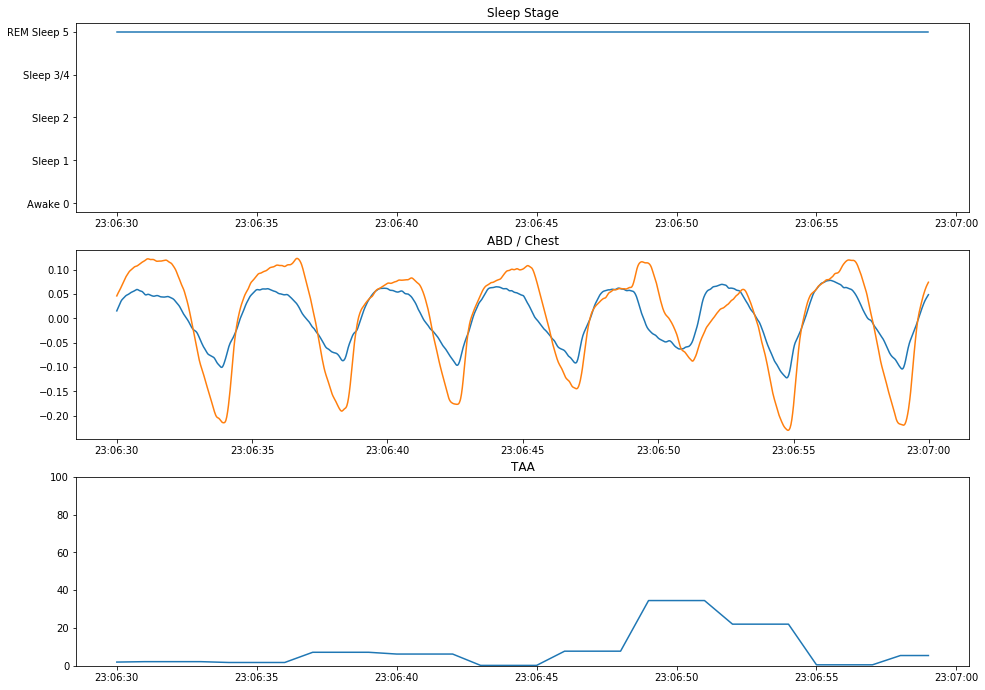

In [357]:
chart_taa(start_time=11_600, window_len=30)

## TODO

* Discard times when awake 
* Calculate % of time over 30% out of sync
* Figure out the breathing rate
* Discard breathing rate out of range

In [307]:
# Minutes in each sleep stage
np.bincount(stages)/60

array([163.25,  75.5 , 140.  , 145.  ,   0.  , 102.  ])

In [319]:
# Study length in hours
len(stages)/60/60

10.429166666666667

In [321]:
# hours awake
sum(stages == 0)/60/60

2.720833333333333

In [317]:
sleep_minutes = sum(stages != 0)/60
sleep_minutes

462.5

In [314]:
# Filter taa by time asleep
asleep_taa = taa[stages != 0]
len(asleep_taa)

27750

In [313]:
# Percent of time sleeping with taa > 30%
sum(asleep_taa > 0.3) / len(asleep_taa)

0.2574054054054054

In [119]:
import librosa
abd_stft = librosa.stft(sigs[0], n_fft=512, win_length=512)

In [120]:
abd_stft[:5,1000:1005]

array([[ 2.2297444e+03+0.0000000e+00j,  2.2297444e+03+0.0000000e+00j,
         2.2297444e+03+0.0000000e+00j,  2.2297444e+03+0.0000000e+00j,
         2.2297444e+03+0.0000000e+00j],
       [-1.1148722e+03+1.8103927e-06j, -1.1148722e+03+4.2418683e-06j,
        -1.1148722e+03-7.2597636e-06j, -1.1148722e+03+4.8980955e-06j,
        -1.1148722e+03+8.4729157e-07j],
       [ 4.3148368e-05-1.1607954e-05j, -3.5863650e-05-2.5851639e-05j,
         2.7103206e-06+4.4517958e-05j,  3.2103282e-05-3.1169391e-05j,
        -4.3877033e-05-5.2358600e-06j],
       [-4.5741639e-05+1.1831351e-05j,  3.9784747e-05+2.8701152e-05j,
        -4.5752799e-06-4.8121641e-05j, -3.4906956e-05+3.2143424e-05j,
         4.8744354e-05+5.8005276e-06j],
       [ 3.3357603e-05-1.4721012e-05j, -1.3998673e-06+1.7351787e-05j,
        -2.4638781e-05+1.3255505e-05j,  1.0010871e-05-3.3202803e-05j,
         1.3037528e-05+5.3128415e-06j]], dtype=complex64)

In [132]:
np.argsort(np.abs(abd_stft[:,3000:3005]), axis=0)[-10:]

array([[207,   6, 205, 205, 147],
       [  6, 205, 202, 147, 205],
       [205, 202,   7,   7,   7],
       [  7,   7,   6, 256,   6],
       [  4,   4,   4,   4,   4],
       [  5,   5,   5,   5,   5],
       [  3,   3,   3,   3,   3],
       [  2,   1,   2,   2,   2],
       [  1,   2,   1,   1,   1],
       [  0,   0,   0,   0,   0]])

In [131]:
fft_freq = librosa.fft_frequencies(sr=200, n_fft=512)
print(f"1 {fft_freq[1]}")
print(f"38 {fft_freq[38]}")
print(f"197 {fft_freq[197]}")
print(f"159 {fft_freq[159]}")
print(f"156 {fft_freq[156]}")

1 0.390625
38 14.84375
197 76.953125
159 62.109375
156 60.9375


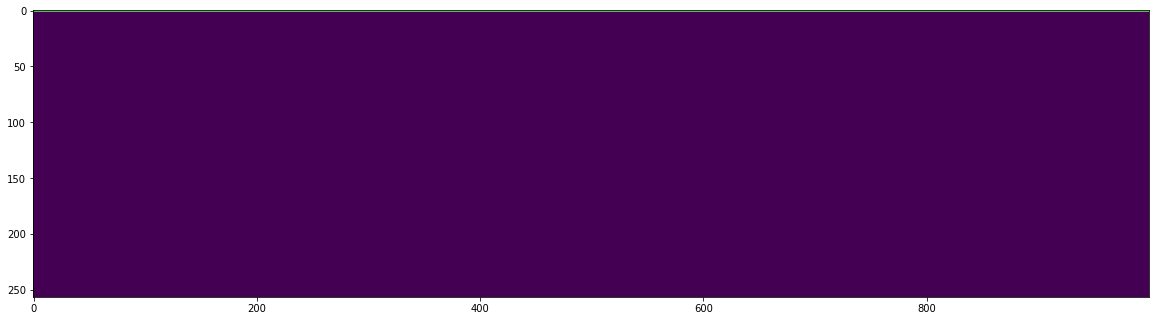

In [122]:
plt.figure(figsize=(20,10))
plt.imshow(np.power(np.abs(abd_stft[:,1000:2000]),0.5))

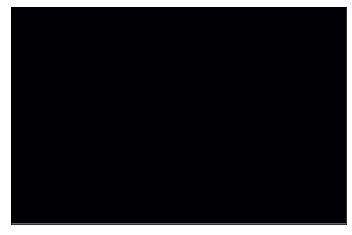

In [142]:
import librosa.display
librosa.display.specshow(np.abs(abd_stft[:,1000:1010]),sr=200)

In [234]:
abd, chest = preprocess(sigs)

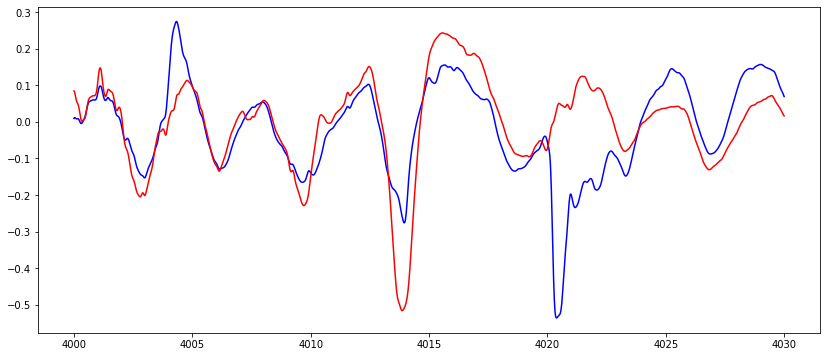

In [292]:
plt.figure(figsize=(14,6))
# plt.plot(sigs[0,rng], 'y')
start = 4_000
end = start + 30
#x = np.arange(start, end)
#plt.ylim(-0.2, 0.2)
plt.plot(np.linspace(start, end, (end-start)*64), abd[start*64:end*64], 'b')
#plt.plot(np.linspace(start, end, (end-start)*200), sigs[0,start*200:end*200], 'g', alpha=0.4)

plt.plot(np.linspace(start, end, (end-start)*64), chest[start*64:end*64], 'r')
#plt.plot(np.linspace(start, end, (end-start)*200), sigs[1,start*200:end*200], 'y', alpha=0.4)

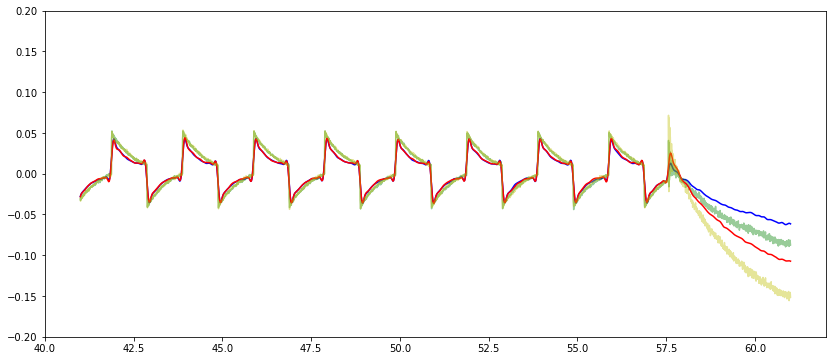

In [267]:
plt.figure(figsize=(14,6))
# plt.plot(sigs[0,rng], 'y')
start = 41
end = start + 20
#x = np.arange(start, end)
plt.ylim(-0.2, 0.2)
plt.plot(np.linspace(start, end, (end-start)*64), abd[start*64:end*64], 'b')
plt.plot(np.linspace(start, end, (end-start)*200), sigs[0,start*200:end*200], 'g', alpha=0.4)

plt.plot(np.linspace(start, end, (end-start)*64), chest[start*64:end*64], 'r')
plt.plot(np.linspace(start, end, (end-start)*200), sigs[1,start*200:end*200], 'y', alpha=0.4)

In [232]:
# resample to 64Hz
abd_64 = signal.resample(sigs[0], int(len(sigs[0])*64/200 ))
chest_64 = signal.resample(sigs[0], int(len(sigs[1])*64/200 ))

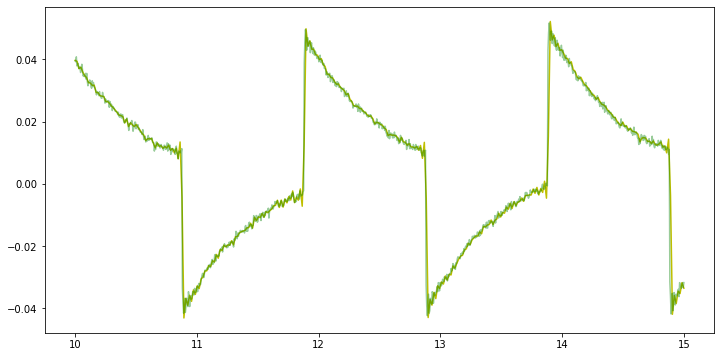

In [231]:
plt.figure(figsize=(12,6))
# plt.plot(sigs[0,rng], 'y')
start, end = 10, 15
#x = np.arange(start, end)
plt.plot(np.linspace(start, end, (end-start)*64), abd_64[start*64:end*64], 'y')
plt.plot(np.linspace(start, end, (end-start)*200), sigs[0,start*200:end*200], 'g', alpha=0.4)

In [220]:
import scipy.signal as signal
bands =   (0, 0.05, 0.1, 5, 10, 32)
desired = (0, 0,    1,   1, 0, 0)
# b_firwin = signal.firwin(numtaps=73, cutoff=5, fs=200, pass_zero=False)
b_firwin = signal.firwin2(73, bands, desired, fs=64)
b_firls = signal.firls(73, bands, desired, fs=64)
#signal.firwin?

In [221]:
#freq, response = signal.freqz(b_firwin)
y = signal.filtfilt(b_firwin, 1, abd_64)
y2 = signal.filtfilt(b_firls, 1, abd_64)

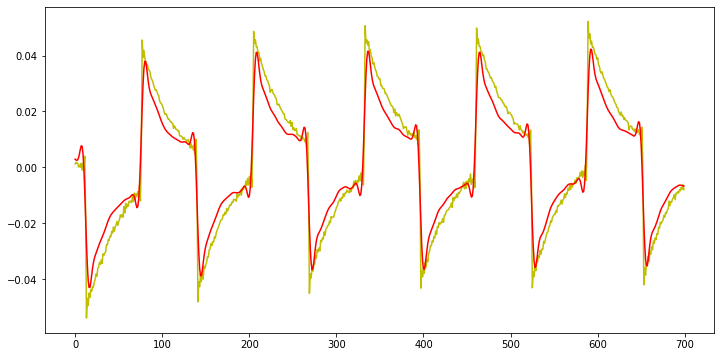

In [227]:
rng = np.arange(300,1000)
plt.figure(figsize=(12,6))
# plt.plot(sigs[0,rng], 'y')
plt.plot(abd_64[rng], 'y')
plt.plot(y[rng], 'r')
#plt.plot(y2[rng], 'g')

In [21]:
signal_labels = f.getSignalLabels()
list(zip(signal_labels, range(len(signal_labels))))

[('Event', 0),
 ('C3', 1),
 ('C4', 2),
 ('O1', 3),
 ('O2', 4),
 ('M1', 5),
 ('M2', 6),
 ('Cchin', 7),
 ('F3', 8),
 ('F4', 9),
 ('F7', 10),
 ('F8', 11),
 ('Fz', 12),
 ('Fp1', 13),
 ('Fp2', 14),
 ('Fpz', 15),
 ('P3', 16),
 ('P4', 17),
 ('ECG3', 18),
 ('T3', 19),
 ('T4', 20),
 ('T5', 21),
 ('T6', 22),
 ('E1', 23),
 ('E2', 24),
 ('Lchin', 25),
 ('Rchin', 26),
 ('ECG2', 27),
 ('ECG1', 28),
 ('Lleg1', 29),
 ('Lleg2', 30),
 ('Rleg1', 31),
 ('Rleg2', 32),
 ('Chest', 33),
 ('ABD', 34),
 ('Airflow', 35),
 ('Snore', 36),
 ('CannulaFlow', 37),
 ('SUM', 38),
 ('Position', 39),
 ('DC2', 40),
 ('DC3', 41),
 ('DC4', 42),
 ('CPress', 43),
 ('CFlow', 44),
 ('Cap', 45),
 ('EtCO2', 46),
 ('EXTSAT', 47),
 ('Pleth', 48),
 ('SAO2', 49),
 ('PR', 50),
 ('DHR', 51)]

In [22]:
f.getNSamples()

array([7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000, 7509000, 7509000, 7509000, 7509000,
       7509000, 7509000, 7509000])